In [6]:
import sys
print(sys.version)

3.6.8 |Anaconda, Inc.| (default, Feb 11 2019, 15:03:47) [MSC v.1915 64 bit (AMD64)]


In [8]:
# Importing dependencies
import numpy as np
np.random.seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import GRU
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
import data_prep_helper
plt.style.use('ggplot')

### Data Preprocessing

In [5]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [12]:
# Loading the dataset
do = data_prep_helper.ChartData()
df = do.df_d["bitcoin_hist"]


In [14]:
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2015-01-01,314.9,318.2,321.4,313.5,12820.0,-1.05%
2015-01-02,315.2,314.9,316.4,313.1,14730.0,0.10%
2015-01-03,287.1,315.2,315.8,284.9,47370.0,-8.91%
2015-01-04,264.7,287.1,289.9,255.9,88770.0,-7.80%
2015-01-05,274.8,264.7,278.3,262.9,54990.0,3.82%


In [15]:
# Correlation matrix
df.corr()['Price']

Price    1.000000
Open     0.997380
High     0.998825
Low      0.998494
Vol.     0.220254
Name: Price, dtype: float64

In [16]:
print(df.describe()["Vol."]) 
df.drop(df[df["Vol."]==0].index, inplace = True) #Dropping rows with volume value 0

count    1.903000e+03
mean     4.528452e+05
std      1.146838e+06
min      1.105000e+04
25%      5.529000e+04
50%      1.165300e+05
75%      4.545650e+05
max      1.543000e+07
Name: Vol., dtype: float64


In [17]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [18]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mse,rmse, r2, Y_test, Y_hat
  

In [19]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [20]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'lower right')
    plt.show()

### Model Building

In [34]:
# Extracting the series
series = df[['Price','High','Low']] # Picking the features
print(series.shape)
print(series.tail())

(1903, 3)
             Price    High     Low
Date                              
2020-03-13  5584.3  5934.3  3869.5
2020-03-14  5182.7  5634.9  5072.2
2020-03-15  5366.3  5863.3  5120.6
2020-03-16  5030.0  5369.3  4477.7
2020-03-17  5271.3  5405.7  4946.5


In [35]:
'''
# Train Val Test Split
train_start = dt.date(1997,1,1)
train_end = dt.date(2006,12,31)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2007,1,1)
val_end = dt.date(2008,12,31)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2009,1,1)
test_end = dt.date(2010,12,31)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)
'''

'\n# Train Val Test Split\ntrain_start = dt.date(1997,1,1)\ntrain_end = dt.date(2006,12,31)\ntrain_data = series.loc[train_start:train_end]\n\nval_start = dt.date(2007,1,1)\nval_end = dt.date(2008,12,31)\nval_data = series.loc[val_start:val_end]\n\ntest_start = dt.date(2009,1,1)\ntest_end = dt.date(2010,12,31)\ntest_data = series.loc[test_start:test_end]\n\nprint(train_data.shape,val_data.shape,test_data.shape)\n'

In [36]:
#creating the train and validation set
train = series[:int(0.7*(len(series)))]
val = series[int(0.7*(len(series))):int(0.85*(len(series)))]
test = series[int(0.85*(len(series))):]

In [37]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train)
val = sc.transform(val)
test = sc.transform(test)
print(train.shape,val.shape,test.shape)

(1332, 3) (285, 3) (286, 3)


In [38]:
timesteps = 40
hl = [40,35]
lr = 1e-4
batch_size = 64
num_epochs = 200

Epoch 00192: early stopping


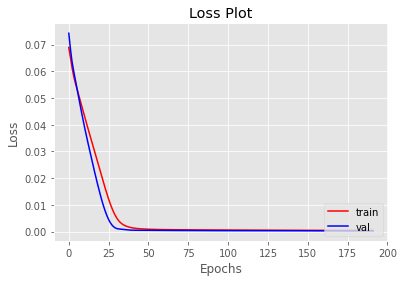

In [39]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MSE = 0.0007257455380740605
RMSE = 0.02693966477285975
R2-Score = 0.850914910607922


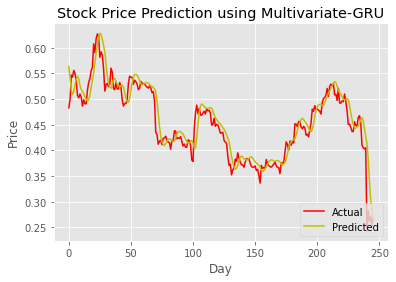

In [40]:
mse,rmse,r2_value,true,predicted = evaluate_model(model,test,40)
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
plot_data(true,predicted)

In [17]:
# Save a model
model.save('MV3-GRU_40_[40,35]_1e-4_64.h5')
#del model  #Deletes the model
# Load a model
#model = load_model('MV3-GRU_40_[40,35]_1e-4_64.h5')

## Cross Validation

In [16]:
timesteps = 40
hl = [40,35]
lr = 1e-4
batch_size = 64
num_epochs = 50

In [17]:
# Extracting the series
series = df[['Close','High','Volume']] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(5670, 3)
                Close       High  Volume
Date                                    
2019-02-15  19.590000  19.639999  146000
2019-02-19  19.549999  19.600000  138100
2019-02-20  19.920000  20.059999  133400
2019-02-21  20.190001  20.790001  167000
2019-02-22  21.000000  21.080000  434100


In [18]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:5400])
series

C:\Users\Navodit\Miniconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([[0.5505618 , 0.55257271, 0.77239184],
       [0.5505618 , 0.55257271, 0.1257898 ],
       [0.54606742, 0.55257271, 0.07847393],
       ...,
       [0.91406745, 0.90693512, 0.02585251],
       [0.93204498, 0.92769575, 0.08074085],
       [0.92737079, 0.92841163, 0.09197897]])

### Split I

In [39]:
#Splitting the data for initial model creation
splits = 5
split_size = 600
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

Split 1
MSE = 8.741484416057362e-05
RMSE = 0.009349590587858574
R-Squared Score = 0.8626941845268219


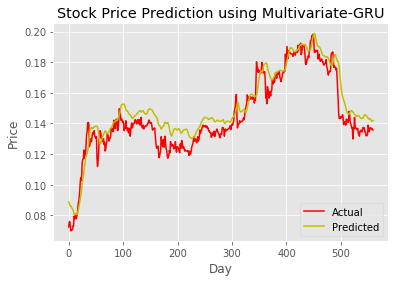

In [43]:
cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()
model,train_error,val_error = fit_model(train,timesteps,hl,lr,batch_size,num_epochs)
train_loss['Split1'] = train_error
val_loss['Split1'] = val_error
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,0])
model.save("MV3-GRU-Split1.h5")

### Split II

Split 2
MSE = 0.00020299839637539626
RMSE = 0.014247750572472705
R-Squared Score = 0.9510760198140408


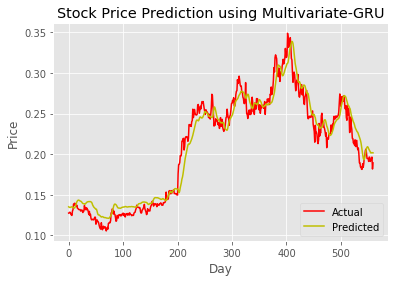

In [45]:
train = series[:4*split_size]
test = series[4*split_size:5*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split2.h5")

### Split III

Split 3
MSE = 8.588678274638782e-05
RMSE = 0.00926751221992115
R-Squared Score = 0.9427491291502208


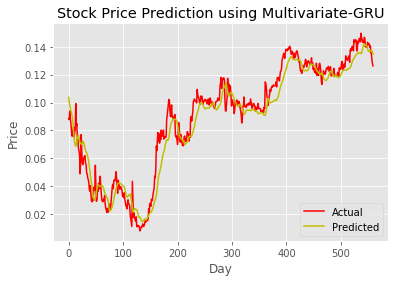

In [57]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
val_loss["Split3"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split3.h5")

### Split IV

Split 4
MSE = 0.0005691851502397929
RMSE = 0.02385760151900842
R-Squared Score = 0.9715605142008245


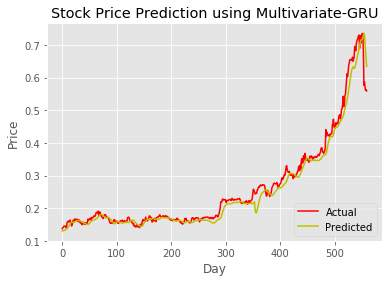

In [66]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history['loss']
val_loss["Split4"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
#cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split4.h5")

### Split V

Split 5
MSE = 0.00045096760122000795
RMSE = 0.0212359977684122
R-Squared Score = 0.9486727335313272


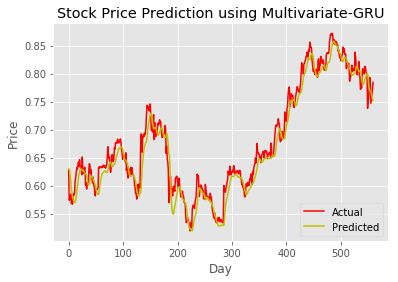

In [63]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split5.h5")

In [67]:
CV_results = pd.DataFrame(cross_val_results,columns=['MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MSE = {}".format(CV_results['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_results['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_results['R2_Score'].mean()))

Avg. MSE = 0.00027925616
Avg. RMSE = 0.015591690800000002
Avg. R2-score = 0.9353505164000001


In [ ]:
CV_results.to_csv('MV3-GRU_CrossValidation.csv')
train_loss.to_csv('MV3-GRU_CrossValidation_TrainLoss.csv')
val_loss.to_csv('MV3-GRU_CrossValidation_ValLoss.csv')